In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import sys 
sys.path.append("../..") 
%aimport p2v

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
model = p2v.P2V()

2024-05-03 11:33:18 -- start loading Mag_venue_info_df
2024-05-03 11:33:18 -- finish.
2024-05-03 11:33:18 -- start loading labeled_journal_info_df
2024-05-03 11:33:18 -- finish.


In [7]:
center_VID = 20605092 # VID for AIDS
center_vname = model.MAG_venue_info_df.at[center_VID, 'OriginalVenue']

abbr_dict = {
    'AIDS': "AIDS",
    'Journal of Acquired Immune Deficiency Syndromes': 'J. Acquir. Immune Defic. Syndr.',
    'Aids Care-psychological and Socio-medical Aspects of Aids\/hiv': 'AIDS Care',
    'Morbidity and Mortality Weekly Report': 'Morb. Mortal. Wkly. Rep.',
    'Family Practice': 'Fam. Pract.',
    'Journal of Public Health': 'J. Public Health',
    'Pediatric Infectious Disease': 'Pediatr. Infect. Dis.',
    'Voprosy onkologii': 'Vopr. Onkol.',
    'Fetal Diagnosis and Therapy': 'Fetal Diagn. Ther.',
    'Leukemia': 'Leukemia',
    'Salud Publica De Mexico': 'Salud Publica Mex.',

    'AIDS Research and Human Retroviruses': 'AIDS Res. Hum. Retrovir.',
    'Antiviral Therapy': 'Antivir. Ther.',
    'Aids Patient Care and Stds': 'AIDS Patient Care STDs',
    'Current Opinion in Infectious Diseases': 'Curr. Opin. Infect. Dis.',
    'International Journal of Std & Aids': 'Int. J. STD AIDS',
    'The Journal of Infectious Diseases': 'J. Infect. Dis.',
    'Journal of the Association of Nurses in AIDS Care': 'J. Assoc. Nurses AIDS Care',
    'Aids and Behavior': 'AIDS Behav.',

    'Hiv Medicine': 'HIV Med.',
    'Hiv Clinical Trials': 'HIV Clin. Trials',
    'Current Opinion in Hiv and Aids': 'Curr. Opin. HIV AIDS',
    'Aids Reviews': 'AIDS Rev.',
    'HIV and AIDS Review': 'HIV AIDS Rev.',

    'The Lancet HIV': 'Lancet HIV',
    'Current Hiv\\/aids Reports': 'Curr. HIV/AIDS Rep.',
    'Journal of the International AIDS Society': 'J. Int. AIDS Soc.',
    'Aids Research and Therapy': 'Aids Res. Ther.',
}

In [35]:
import pandas as pd
import matplotlib.patheffects as path_effects
from adjustText import adjust_text 

def plot_knn_map(start_year: int, end_year: int, d: int, w: int, model: p2v.P2V,
                 rotate_180=False, y_flip=False, rotate_90=False, rotate_90_clockwise=False, 
                 auto_zoom=False, crop=False, up_lim=None, low_lim=None, left_lim=None, right_lim=None,
                 annotate=False, center_VID=None, neighbor_VID_list=None, abbr_dict=None,
                 title=True, legend=True, axis_off=True):
    VID_labeled = model.load_VID_labeled(start_year, end_year, d, w)
    wv_2d = model.load_wv_2d(start_year, end_year, d, w)
    
    plot_df = pd.DataFrame(wv_2d)
    plot_df = plot_df.loc[plot_df.VID.isin(VID_labeled['VID'])]
    plot_df['label'] = VID_labeled['label']
    plot_df['year_founded'] = VID_labeled['year_founded']
    plot_df['is_new'] = plot_df['year_founded'].apply(lambda x: 
                                                      0 if x==None
                                                      else 1 if int(x)>start_year
                                                      else 0)

    fig = plt.figure(figsize=(10, 10), dpi=300)
    ax1 = plt.gca()
    if title:
        ax1.set_title("Neighbors of {} ({}s)".format(center_vname, start_year))
    ax1.set_aspect('equal')
    
    if annotate:
        point_alpha = 0.3
    else:
        point_alpha = 1.0

    if y_flip:
        plot_df['x_val'] = -1 * plot_df['x_val']
    original_x = plot_df['x_val']
    original_y = plot_df['y_val']
    if rotate_180:
        plot_df['x_val'] = -1 * original_x
        plot_df['y_val'] = -1 * original_y
    if rotate_90:
        plot_df['x_val'] = -1 * original_y
        plot_df['y_val'] = original_x
    if rotate_90_clockwise:
        plot_df['x_val'] = original_y
        plot_df['y_val'] = -1 * original_x
    
    sns.scatterplot(data=plot_df, 
                    x='x_val', 
                    y='y_val', 
                    hue='label',
                    hue_order=model.discipline2color.keys(),
                    palette=model.discipline2color,
                    alpha=point_alpha,
                    s=5,
                    ax=ax1)
    if legend:
        ax1.legend(fontsize=6, 
                   ncols=3, 
                   frameon=False,
                   loc='upper center',
                   bbox_to_anchor=(0.5, 0),
                   title='%d Disciplines in This Map' %len(plot_df['label'].unique()))
    else:
        ax1.get_legend().remove()
    if axis_off:  
        ax1.axis('off')
    
    if annotate:
        texts = []
        text = plt.text(plot_df[plot_df.VID==center_VID].x_val.values[0], 
                                plot_df[plot_df.VID==center_VID].y_val.values[0], 
                                center_vname,
                                fontsize=20,
                                color='white',
                                fontweight='bold',
                                ha='center')
        text.set_path_effects([path_effects.Stroke(linewidth=1.25, foreground='black'),
                               path_effects.Normal()])
        texts.append(text)
        for VID in neighbor_VID_list:
            text = plt.text(plot_df[plot_df.VID==VID].x_val.values[0], 
                            plot_df[plot_df.VID==VID].y_val.values[0], 
                            abbr_dict[model.MAG_venue_info_df.at[VID, 'OriginalVenue']],
                            fontsize=12,
                            color='white',
                            fontweight='bold',
                            ha='center')
            text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
            texts.append(text)
        
        neighbor_VID_list.append(center_VID)
        neighbor_df = plot_df.loc[plot_df.VID.isin(neighbor_VID_list)]
        sns.scatterplot(data=neighbor_df, 
                        x='x_val', 
                        y='y_val', 
                        hue='label',
                        hue_order = model.discipline2color.keys(),
                        palette=model.discipline2color,
                        s=25,
                        ax=ax1,
                        legend=False)
        if auto_zoom:
            x_span = neighbor_df.x_val.max() - neighbor_df.x_val.min()
            y_span = neighbor_df.y_val.max() - neighbor_df.y_val.min()
            
            ax1.set_xlim(neighbor_df.x_val.min() - x_span*0.1, neighbor_df.x_val.max() + x_span*0.1)
            ax1.set_ylim(neighbor_df.y_val.min() - y_span*0.1, neighbor_df.y_val.max() + y_span*0.1)
        if crop:
            ax1.set_xlim(left_lim, right_lim)
            ax1.set_ylim(low_lim, up_lim)
        
        adjust_text(texts, arrowprops=dict(arrowstyle='->', lw=0.6, color='red'))

    return fig

# 1980s

2024-05-03 11:34:35 -- start loading word vectors...
2024-05-03 11:34:35 -- word vectors loaded, and its shape is: (9337, 100)
2024-05-03 11:34:35 -- start loading VID_labeled...
2024-05-03 11:34:35 -- finish.
number of neighbors:  10
Journal of Acquired Immune Deficiency Syndromes
Aids Care-psychological and Socio-medical Aspects of Aids\/hiv
Morbidity and Mortality Weekly Report
Family Practice
Journal of Public Health
Pediatric Infectious Disease
Voprosy onkologii
Fetal Diagnosis and Therapy
Leukemia
Salud Publica De Mexico
2024-05-03 11:34:35 -- start loading VID_labeled...
2024-05-03 11:34:35 -- finish.
2024-05-03 11:34:35 -- start loading wv_2d...
2024-05-03 11:34:35 -- finish.


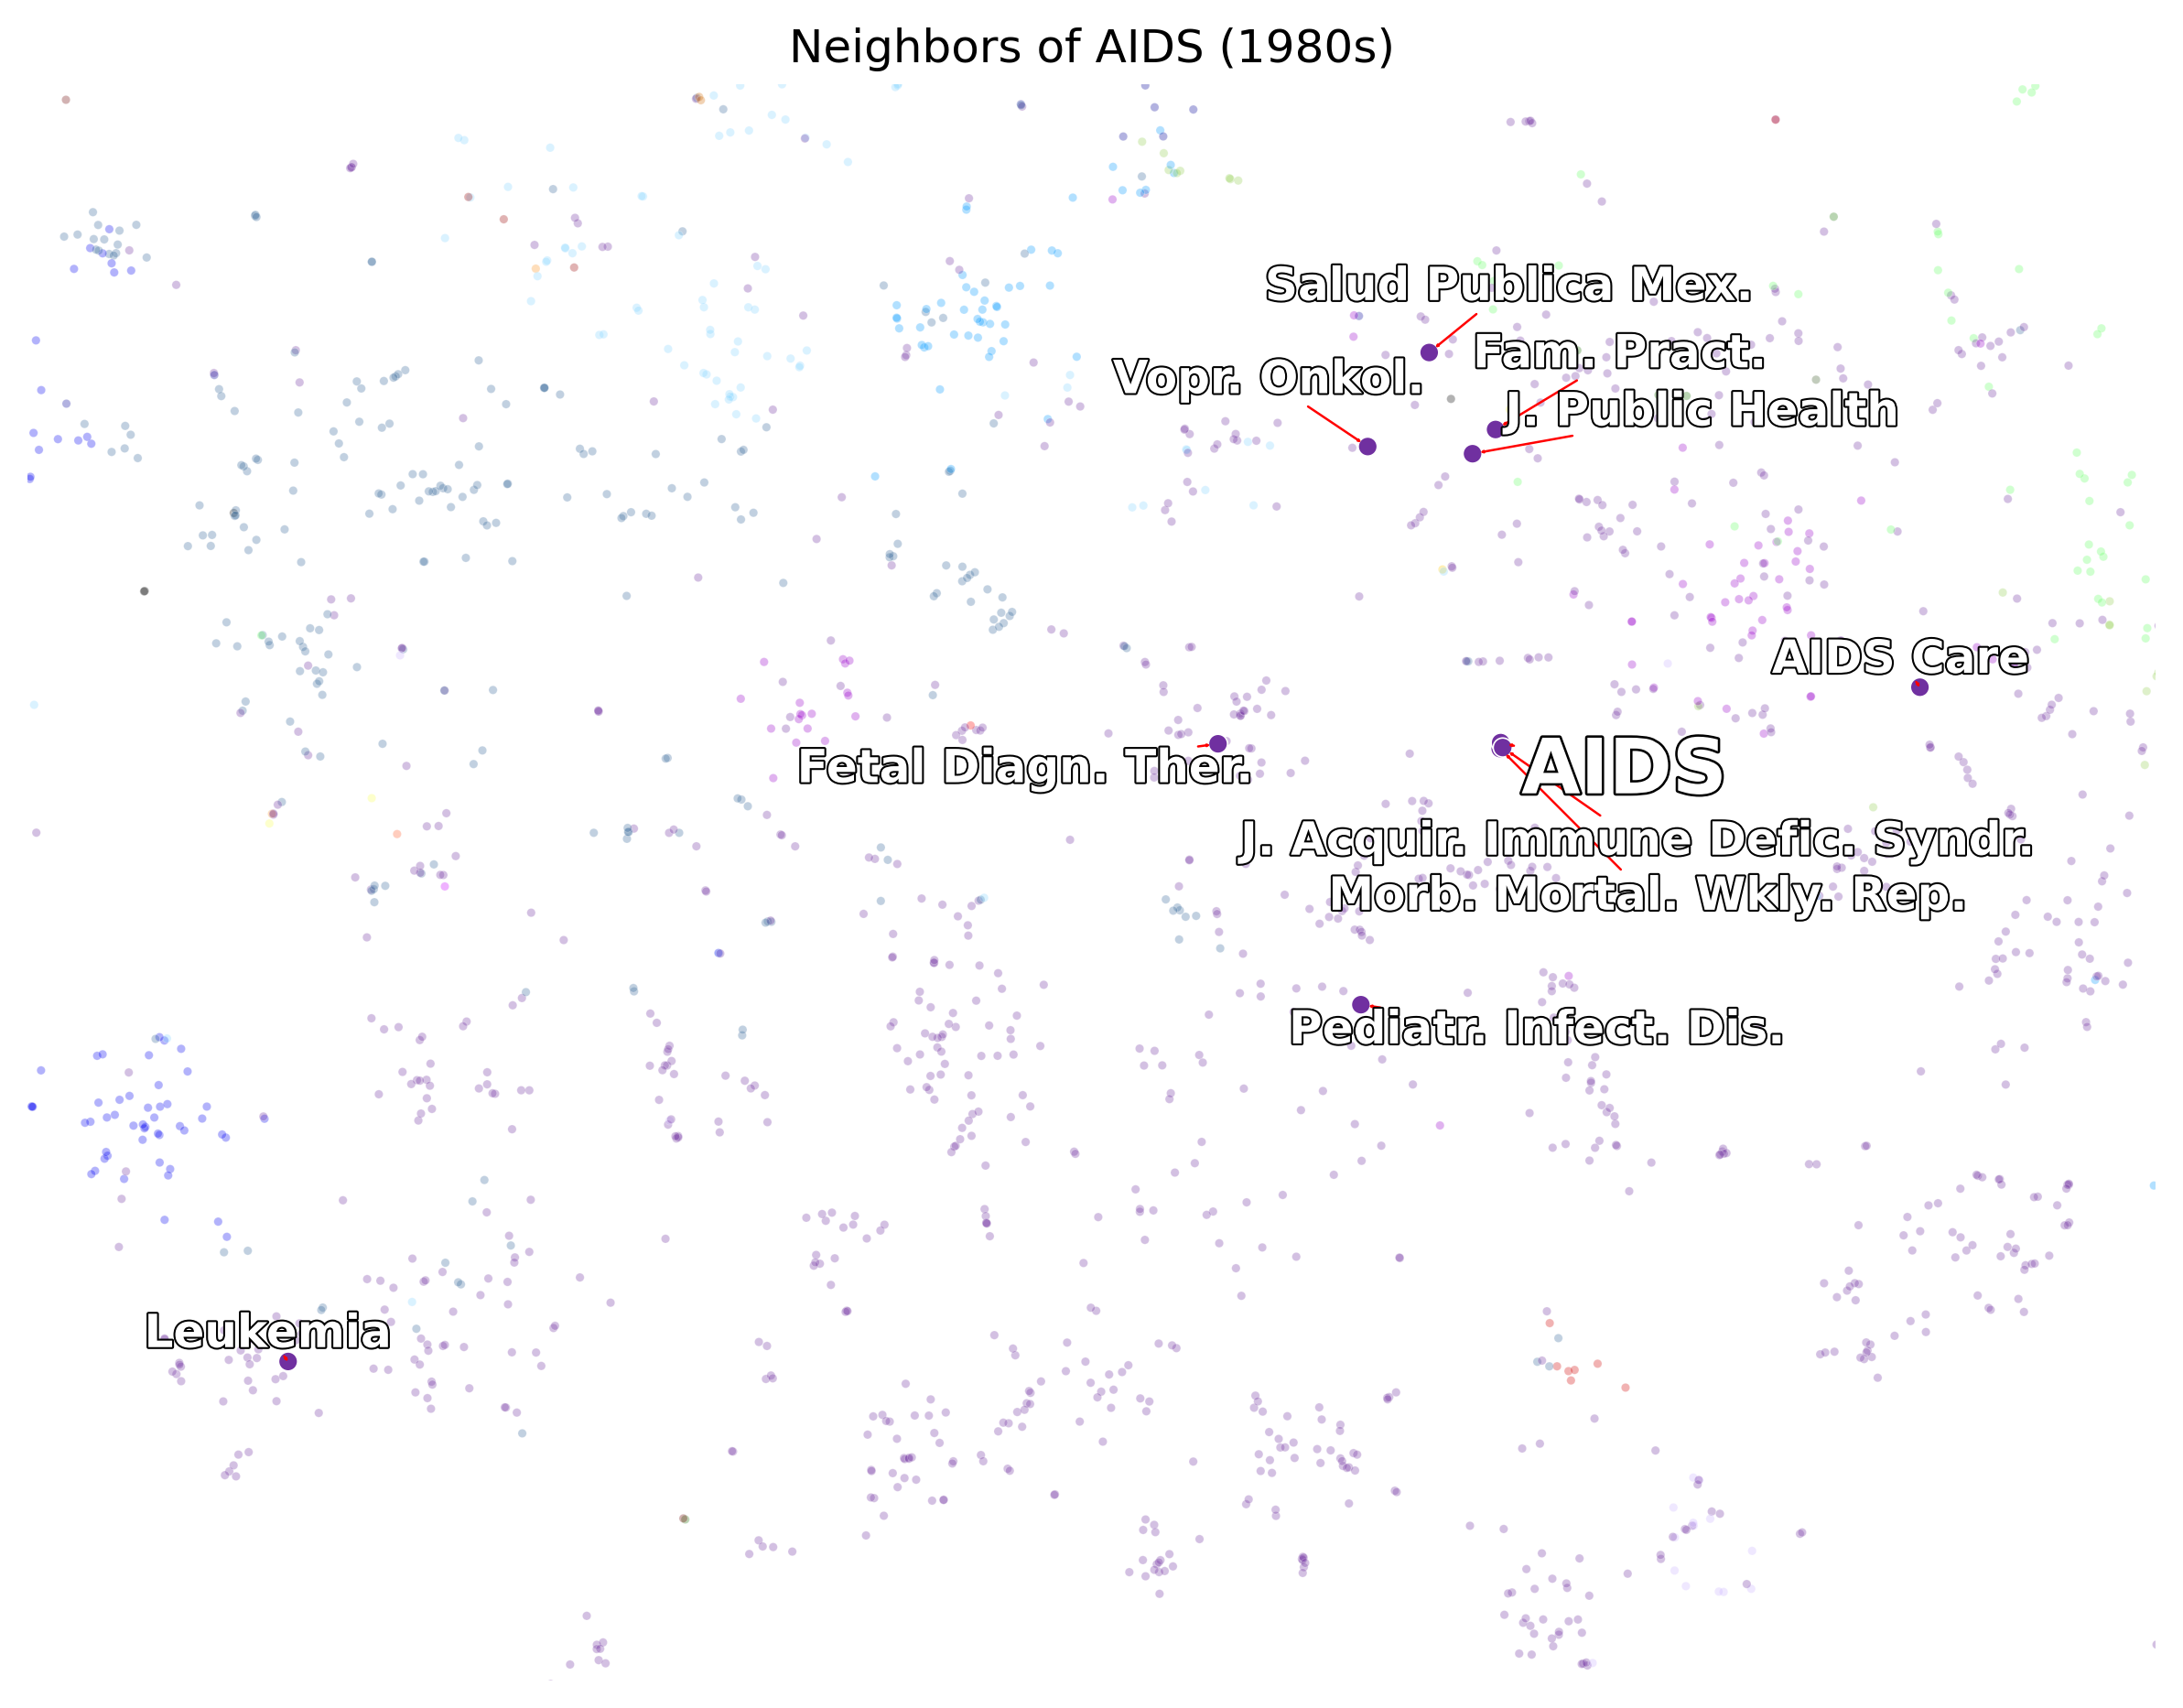

In [9]:
start_year, end_year = 1980, 1989
wv = model.load_wv(start_year, end_year, 100, 10)

VID_labeled = model.load_VID_labeled(start_year, end_year, 100, 10)
tups = wv.most_similar(center_VID, topn=20)
neighbor_VID_list = []
for tup in tups:  
    neighbor_VID = tup[0]
    if neighbor_VID in VID_labeled['VID']:
        neighbor_VID_list.append(neighbor_VID)
    if len(neighbor_VID_list) >= 10:
        break
print('number of neighbors: ', len(neighbor_VID_list))
for neighbor_VID in neighbor_VID_list:
    print(model.MAG_venue_info_df.at[neighbor_VID, 'OriginalVenue'])

fig1 = plot_knn_map(1980,1989, 100, 10, model,
                    y_flip=False, rotate_90_clockwise=True, legend=False,
                    crop=True, left_lim=-50, right_lim=30, low_lim=-70, up_lim=-10,
                    annotate=True, center_VID=center_VID, abbr_dict=abbr_dict, neighbor_VID_list=neighbor_VID_list)

In [10]:
fig1.savefig('knn_map_of_{}_{}_to_{}.png'.format(center_vname, start_year, end_year), 
             dpi = 300, 
             facecolor='white', 
             transparent=False, 
             bbox_inches='tight')

# 1990s

2024-05-03 11:37:26 -- start loading word vectors...
2024-05-03 11:37:26 -- word vectors loaded, and its shape is: (15019, 100)
2024-05-03 11:37:26 -- start loading VID_labeled...
2024-05-03 11:37:26 -- finish.
number of neighbors:  10
Journal of Acquired Immune Deficiency Syndromes
AIDS Research and Human Retroviruses
Antiviral Therapy
Aids Patient Care and Stds
Current Opinion in Infectious Diseases
International Journal of Std & Aids
The Journal of Infectious Diseases
Journal of the Association of Nurses in AIDS Care
Aids and Behavior
Aids Care-psychological and Socio-medical Aspects of Aids\/hiv
2024-05-03 11:37:26 -- start loading VID_labeled...
2024-05-03 11:37:26 -- finish.
2024-05-03 11:37:26 -- start loading wv_2d...
2024-05-03 11:37:26 -- finish.


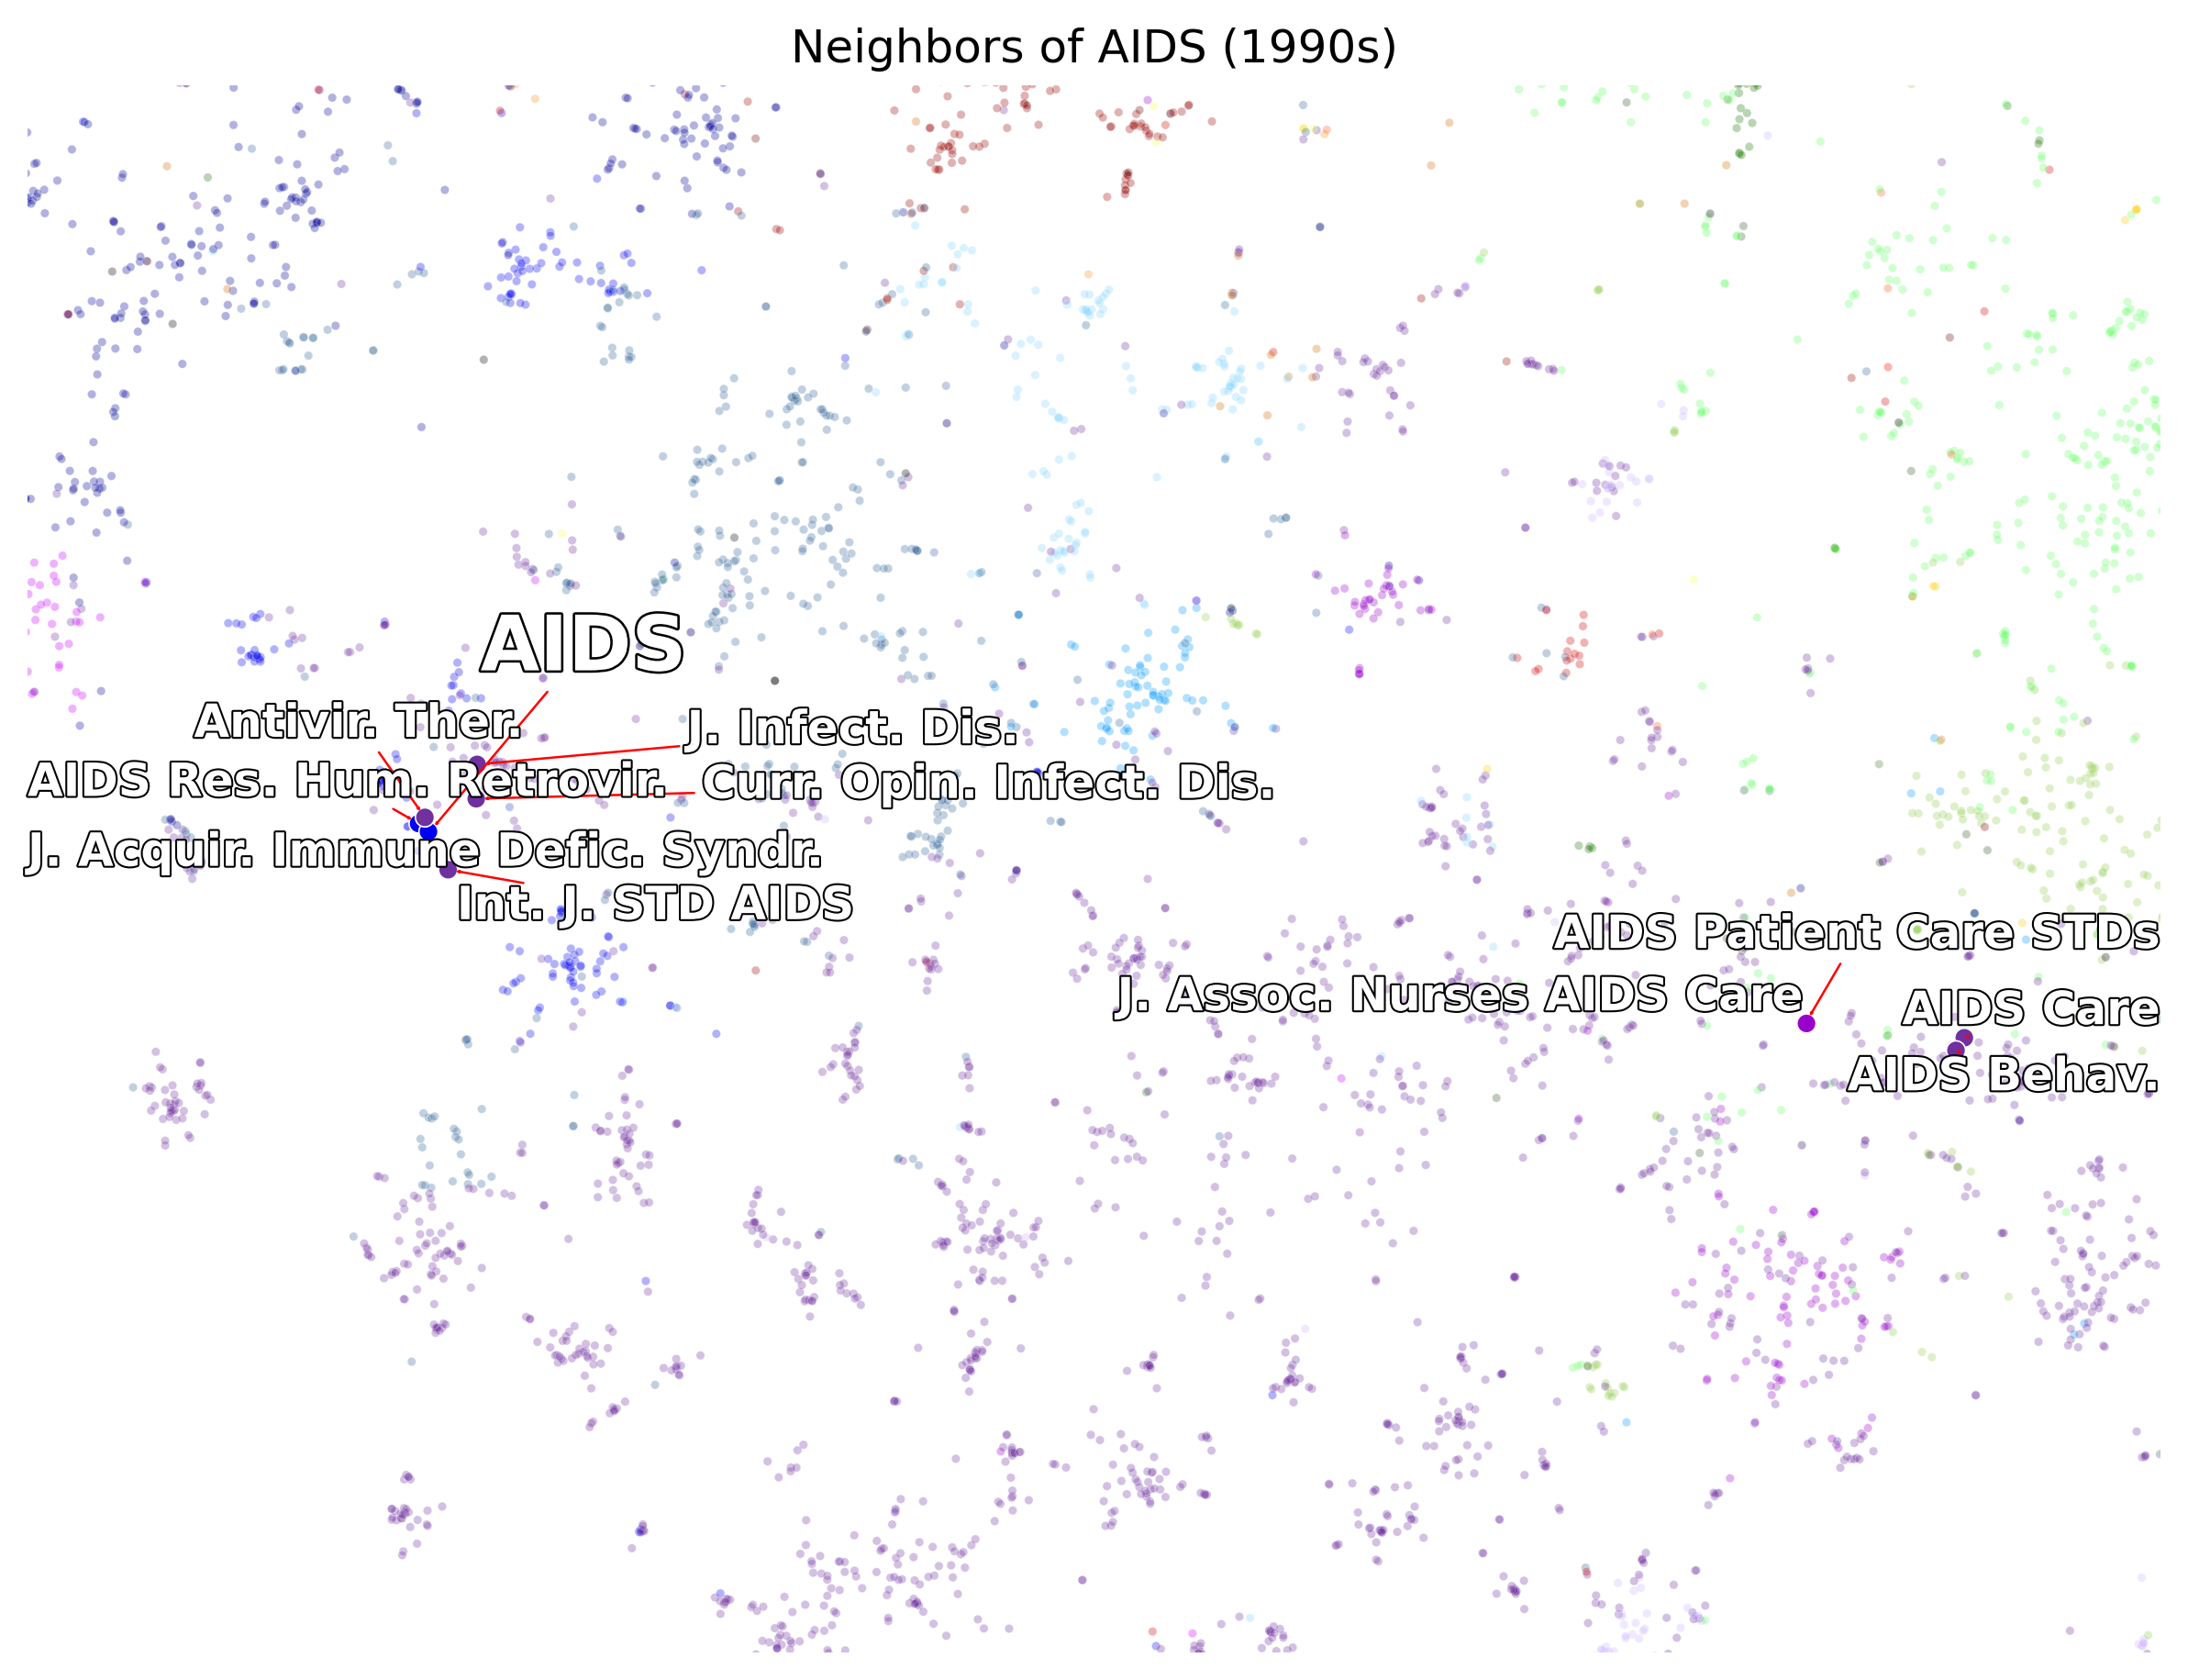

In [12]:
start_year, end_year = 1990, 1999
wv = model.load_wv(start_year, end_year, 100, 10)

VID_labeled = model.load_VID_labeled(start_year, end_year, 100, 10)
tups = wv.most_similar(center_VID, topn=20)
neighbor_VID_list = []
for tup in tups:
    neighbor_VID = tup[0]
    if neighbor_VID in VID_labeled['VID']:
        neighbor_VID_list.append(neighbor_VID)
    if len(neighbor_VID_list) >= 10:
        break
print('number of neighbors: ', len(neighbor_VID_list))
for neighbor_VID in neighbor_VID_list:
    print(model.MAG_venue_info_df.at[neighbor_VID, 'OriginalVenue'])

fig2 = plot_knn_map(start_year, end_year, 100, 10, model,
                    y_flip=False, rotate_90_clockwise=True, legend=False, axis_off=True,
                    crop=True, left_lim=-70, right_lim=28, low_lim=-66, up_lim=6, 
                    annotate=True, center_VID=center_VID, abbr_dict=abbr_dict, neighbor_VID_list=neighbor_VID_list)

In [15]:
fig2.savefig('knn_map_of_{}_{}_to_{}.png'.format(center_vname, start_year, end_year), 
             dpi = 300, 
             facecolor='white', 
             transparent=False, 
             bbox_inches='tight')

# 2000s

2024-05-03 11:47:37 -- start loading word vectors...
2024-05-03 11:47:37 -- word vectors loaded, and its shape is: (27460, 100)
2024-05-03 11:47:37 -- start loading VID_labeled...
2024-05-03 11:47:37 -- finish.
number of neighbors:  10
Journal of Acquired Immune Deficiency Syndromes
Hiv Medicine
Antiviral Therapy
Hiv Clinical Trials
Current Opinion in Hiv and Aids
Aids Reviews
AIDS Research and Human Retroviruses
Aids Care-psychological and Socio-medical Aspects of Aids\/hiv
Aids Patient Care and Stds
HIV and AIDS Review
2024-05-03 11:47:37 -- start loading VID_labeled...
2024-05-03 11:47:37 -- finish.
2024-05-03 11:47:37 -- start loading wv_2d...
2024-05-03 11:47:37 -- finish.


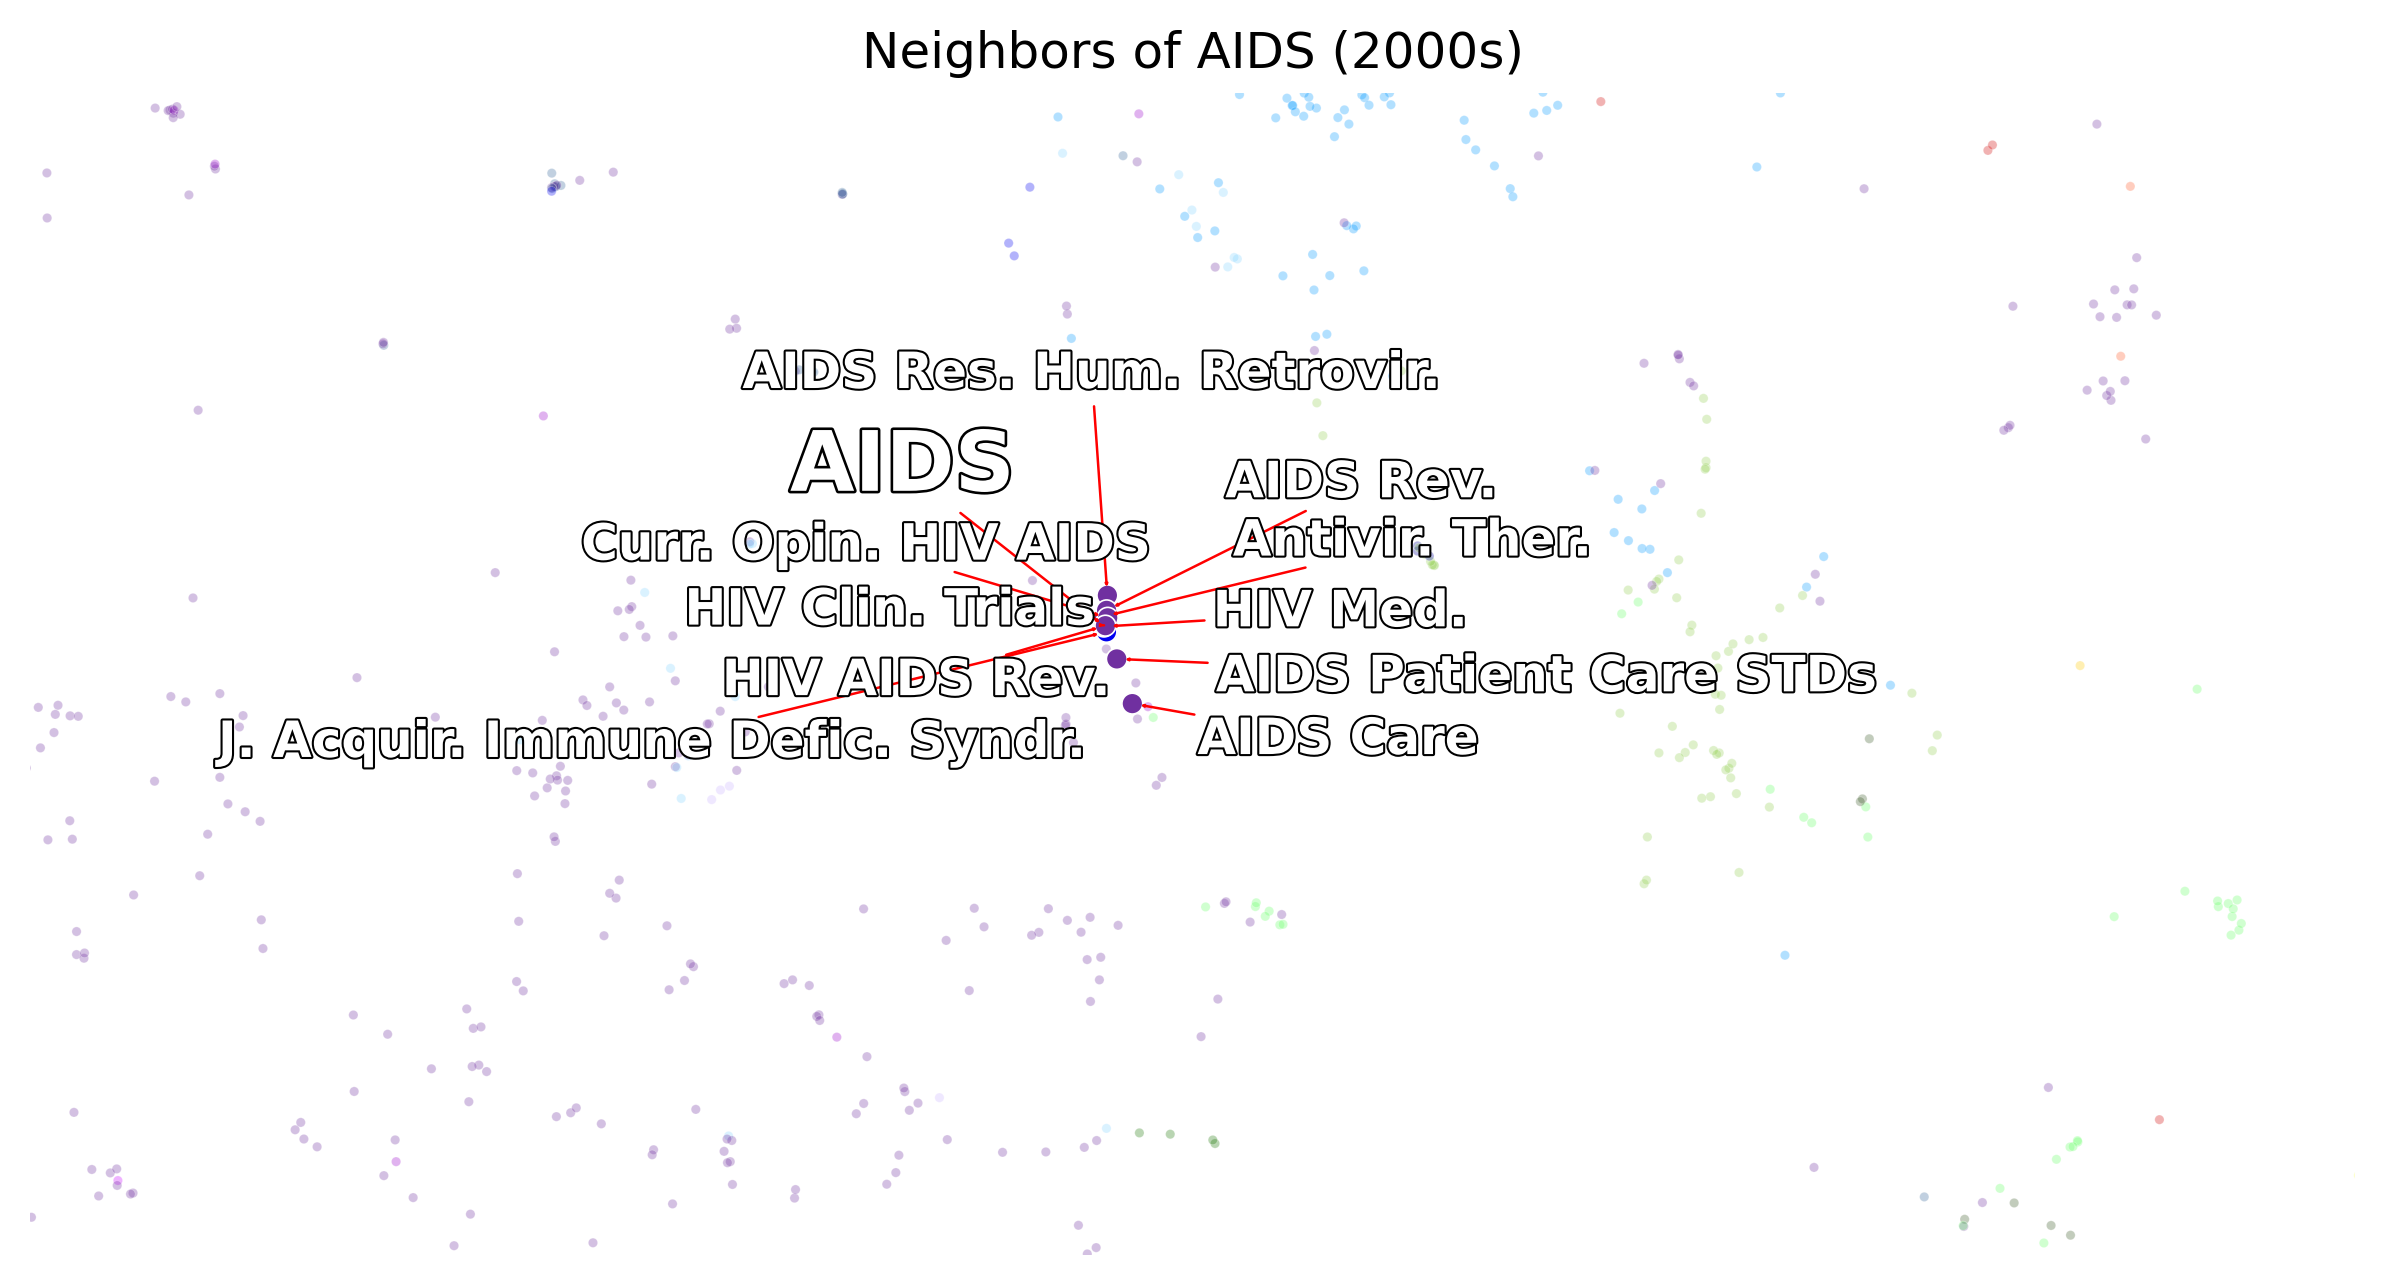

In [38]:
start_year, end_year = 2000, 2009
wv = model.load_wv(start_year, end_year, 100, 10)

VID_labeled = model.load_VID_labeled(start_year, end_year, 100, 10)
tups = wv.most_similar(center_VID, topn=20)
neighbor_VID_list = []
for tup in tups:  
    neighbor_VID = tup[0]
    if neighbor_VID in VID_labeled['VID']:
        neighbor_VID_list.append(neighbor_VID)
    if len(neighbor_VID_list) >= 10:
        break
print('number of neighbors: ', len(neighbor_VID_list))
for neighbor_VID in neighbor_VID_list:
    print(model.MAG_venue_info_df.at[neighbor_VID, 'OriginalVenue'])

fig3=plot_knn_map(start_year, end_year, 100, 10, model,
                  y_flip=True, rotate_180=True, legend=False, axis_off=True,
                  crop=True, left_lim=-35, right_lim=-5, low_lim=-20, up_lim=-5,
                  annotate=True, center_VID=center_VID, abbr_dict=abbr_dict, neighbor_VID_list=neighbor_VID_list)

In [39]:
fig3.savefig('knn_map_of_{}_{}_to_{}.png'.format(center_vname, start_year, end_year), 
             dpi = 300, 
             facecolor='white', 
             transparent=False, 
             bbox_inches='tight')

# 2010s

2024-05-03 11:47:06 -- start loading word vectors...
2024-05-03 11:47:06 -- word vectors loaded, and its shape is: (37594, 100)
2024-05-03 11:47:06 -- start loading VID_labeled...
2024-05-03 11:47:06 -- finish.
number of neighbors:  10
Journal of Acquired Immune Deficiency Syndromes
The Lancet HIV
Current Hiv\/aids Reports
Journal of the International AIDS Society
AIDS Research and Human Retroviruses
Hiv Medicine
Aids Research and Therapy
Current Opinion in Hiv and Aids
Aids Patient Care and Stds
Aids Reviews
2024-05-03 11:47:06 -- start loading VID_labeled...
2024-05-03 11:47:06 -- finish.
2024-05-03 11:47:06 -- start loading wv_2d...
2024-05-03 11:47:06 -- finish.


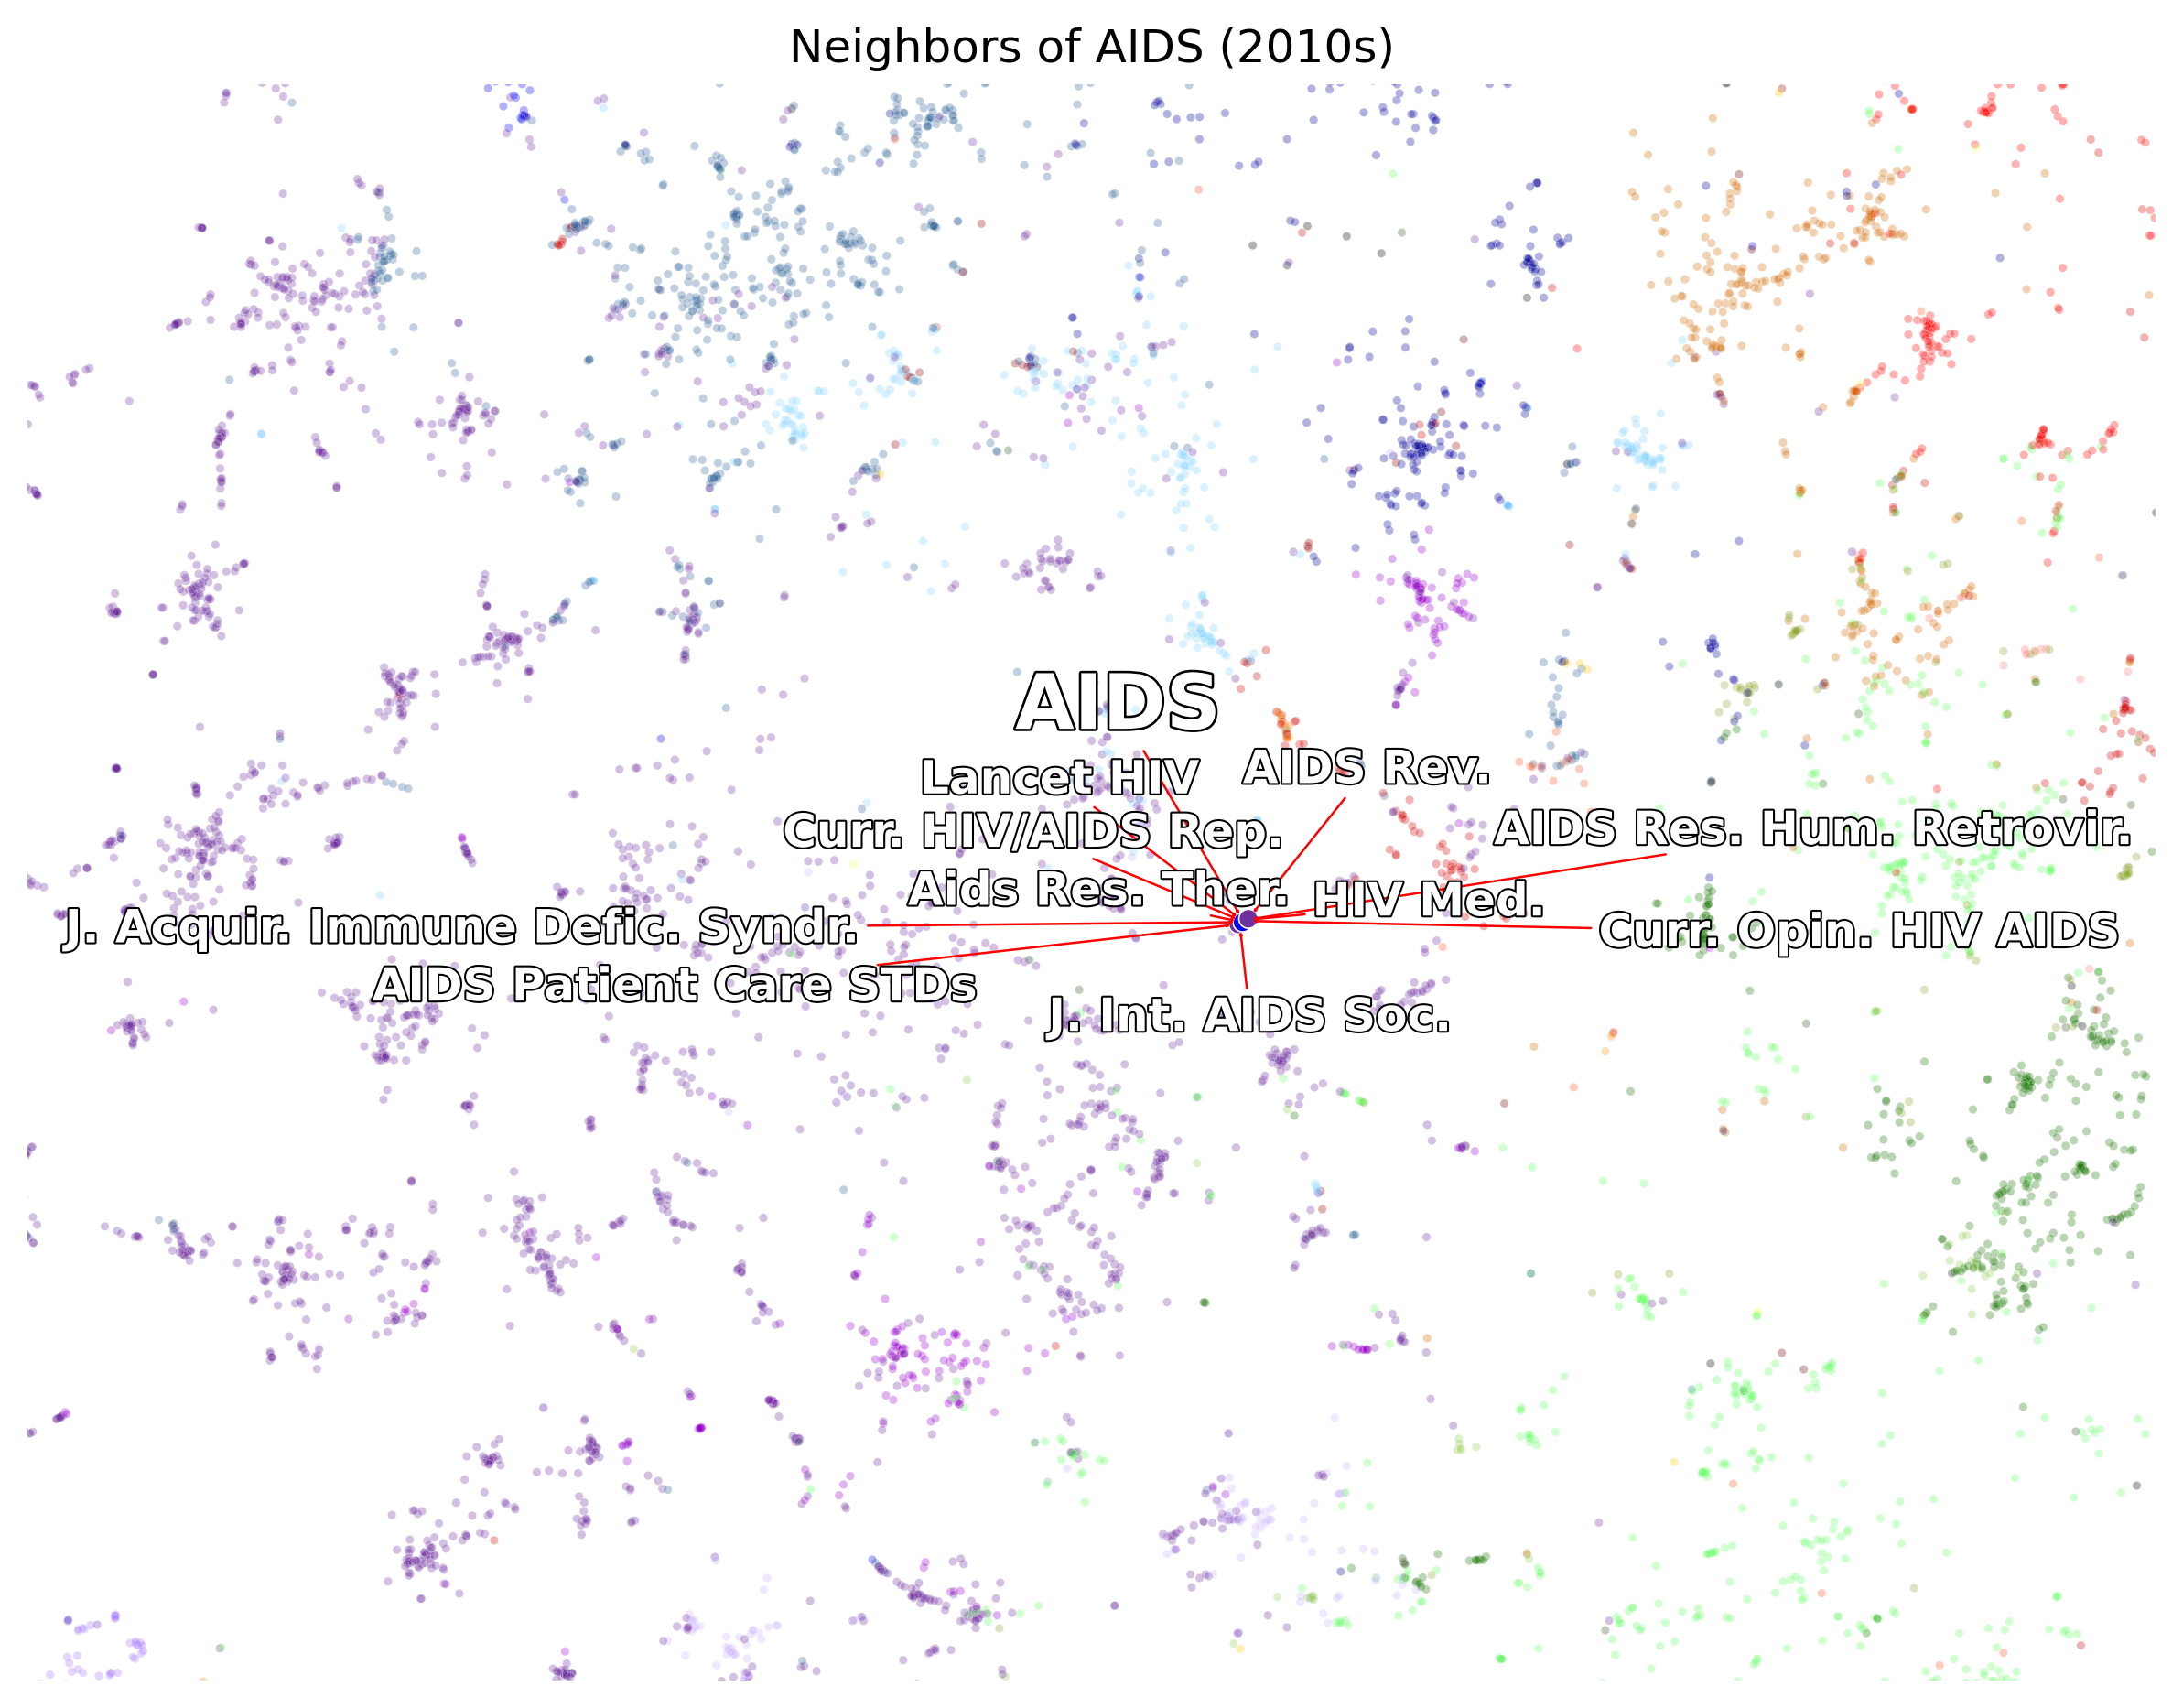

In [36]:
start_year, end_year = 2010, 2021
wv = model.load_wv(start_year, end_year, 100, 10)

VID_labeled = model.load_VID_labeled(start_year, end_year, 100, 10)
tups = wv.most_similar(center_VID, topn=20)
neighbor_VID_list = []
for tup in tups:  
    neighbor_VID = tup[0]
    if neighbor_VID in VID_labeled['VID']:
        neighbor_VID_list.append(neighbor_VID)
    if len(neighbor_VID_list) >= 10:
        break
print('number of neighbors: ', len(neighbor_VID_list))
for neighbor_VID in neighbor_VID_list:
    print(model.MAG_venue_info_df.at[neighbor_VID, 'OriginalVenue'])

fig4 = plot_knn_map(start_year, end_year, 100, 10, model,
                    y_flip=False, rotate_180=False, legend=False, axis_off=True,
                    crop=True, left_lim=-62, right_lim=10, low_lim=-23, up_lim=31,
                    annotate=True, center_VID=center_VID, abbr_dict=abbr_dict, neighbor_VID_list=neighbor_VID_list)

In [37]:
fig4.savefig('knn_map_of_{}_{}_to_{}.png'.format(center_vname, start_year, end_year), 
             dpi = 300, 
             facecolor='white', 
             transparent=False, 
             bbox_inches='tight')

# general

In [32]:
import pandas as pd
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from adjustText import adjust_text 

def plot_tiny_knn_map(model: p2v.P2V, ax, plot_df: pd.DataFrame,
                 rotate_180=False, y_flip=False, rotate_90=False, rotate_90_clockwise=False, 
                 auto_zoom=False, crop=False, up_lim=None, low_lim=None, left_lim=None, right_lim=None,
                 annotate=False, highlight=False, center_VID=None, neighbor_VID_list=None, mark_d=False,
                legend=True, axis_off=True):
    ax.set_aspect('equal')

    if annotate:
        highlight = True

    if highlight:
        point_alpha = 0.05
    else:
        point_alpha = 1.0

    if y_flip:
        plot_df['x_val'] = -1 * plot_df['x_val']
    original_x = plot_df['x_val']
    original_y = plot_df['y_val']
    if rotate_180:
        plot_df['x_val'] = -1 * original_x
        plot_df['y_val'] = -1 * original_y
    if rotate_90:
        plot_df['x_val'] = -1 * original_y
        plot_df['y_val'] = original_x
    if rotate_90_clockwise:
        plot_df['x_val'] = original_y
        plot_df['y_val'] = -1 * original_x
    
    sns.scatterplot(data=plot_df, 
                    x='x_val', 
                    y='y_val', 
                    hue='label',
                    hue_order=model.discipline2color.keys(),
                    palette=model.discipline2color,
                    alpha=point_alpha,
                    s=5,
                    ax=ax)
    if legend:
        ax.legend(fontsize=6, 
                  ncols=3, 
                  frameon=False,
                  loc='upper center',
                  bbox_to_anchor=(0.5, 0),
                  title='%d Disciplines in This Map' %len(plot_df['label'].unique()))
    else:
        ax.get_legend().remove()
    if axis_off:  
        ax.axis('off')

    if auto_zoom:
        x_span = neighbor_df.x_val.max() - neighbor_df.x_val.min()
        y_span = neighbor_df.y_val.max() - neighbor_df.y_val.min()
        
        ax.set_xlim(neighbor_df.x_val.min() - x_span*0.1, neighbor_df.x_val.max() + x_span*0.1)
        ax.set_ylim(neighbor_df.y_val.min() - y_span*0.1, neighbor_df.y_val.max() + y_span*0.1)
    if crop:
        ax.set_xlim(left_lim, right_lim)
        ax.set_ylim(low_lim, up_lim)

    if highlight:
        neighbor_VID_list.append(center_VID)
        neighbor_df = plot_df.loc[plot_df.VID.isin(neighbor_VID_list)]
        neighbor_df.loc[:,'venue_name'] = neighbor_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])

        if mark_d:
            c_x = neighbor_df[neighbor_df.VID==center_VID].x_val.values[0]
            c_y = neighbor_df[neighbor_df.VID==center_VID].y_val.values[0]

            last_neighbor_VID = neighbor_VID_list[-2]
            d_x = neighbor_df[neighbor_df.VID==last_neighbor_VID].x_val.values[0]
            d_y = neighbor_df[neighbor_df.VID==last_neighbor_VID].y_val.values[0]
            l = mlines.Line2D([c_x, d_x], [c_y, d_y],
                              linewidth=1, color='r', zorder=2)
            ax.add_line(l)
            ax.text((c_x+d_x)/2-6, (c_y+d_y)/2-3, 'd', style='italic')
            ax.text(d_x+1, d_y+2, '10$^{th}$-NN')
    
            sns.scatterplot(data=neighbor_df[neighbor_df.VID==last_neighbor_VID], 
                            x='x_val', 
                            y='y_val', 
                            hue='label',
                            hue_order = model.discipline2color.keys(),
                            palette=model.discipline2color,
                            s=30,
                            alpha=.9,
                            zorder=3,
                            ax=ax,
                            legend=False)
        sns.scatterplot(data=neighbor_df[neighbor_df.VID==center_VID], 
                        x='x_val', 
                        y='y_val', 
                        hue='label',
                        hue_order = model.discipline2color.keys(),
                        palette=model.discipline2color,
                        s=200,
                        alpha=.9,
                        zorder=3,
                        marker='*', # highlight the center periodical
                        ax=ax,
                        legend=False)
        sns.scatterplot(data=neighbor_df, 
            x='x_val', 
            y='y_val', 
            hue='label',
            hue_order = model.discipline2color.keys(),
            palette=model.discipline2color,
            s=30,
            alpha=.9,
            zorder=1,
            ax=ax,
            legend=False)

    if annotate:
        texts = []
        text = ax.text(plot_df[plot_df.VID==center_VID].x_val.values[0], 
                        plot_df[plot_df.VID==center_VID].y_val.values[0], 
                        center_vname,
                        fontsize=20,
                        color='white',
                        fontweight='bold',
                        ha='center')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                               path_effects.Normal()])
        texts.append(text)
        for VID in neighbor_VID_list:
            text = ax.text(plot_df[plot_df.VID==VID].x_val.values[0], 
                            plot_df[plot_df.VID==VID].y_val.values[0], 
                            abbr_dict[model.MAG_venue_info_df.at[VID, 'OriginalVenue']],
                            fontsize=12,
                            color='white',
                            fontweight='bold',
                            ha='center')
            text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()])
            texts.append(text)

        adjust_text(texts, arrowprops=dict(arrowstyle='->', lw=0.6, color='red'))


2024-05-03 11:46:23 -- start loading word vectors...
2024-05-03 11:46:23 -- word vectors loaded, and its shape is: (9337, 100)
2024-05-03 11:46:23 -- start loading VID_labeled...
2024-05-03 11:46:23 -- finish.
number of neighbors:  10
Journal of Acquired Immune Deficiency Syndromes
Aids Care-psychological and Socio-medical Aspects of Aids\/hiv
Morbidity and Mortality Weekly Report
Family Practice
Journal of Public Health
Pediatric Infectious Disease
Voprosy onkologii
Fetal Diagnosis and Therapy
Leukemia
Salud Publica De Mexico
2024-05-03 11:46:23 -- start loading wv_2d...
2024-05-03 11:46:23 -- finish.
2024-05-03 11:46:23 -- start loading word vectors...
2024-05-03 11:46:23 -- word vectors loaded, and its shape is: (15019, 100)
2024-05-03 11:46:23 -- start loading VID_labeled...
2024-05-03 11:46:23 -- finish.
number of neighbors:  10
Journal of Acquired Immune Deficiency Syndromes
AIDS Research and Human Retroviruses
Antiviral Therapy
Aids Patient Care and Stds
Current Opinion in Infec

/tmp/ipykernel_3473845/3008816805.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbor_df.loc[:,'venue_name'] = neighbor_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])
/tmp/ipykernel_3473845/3008816805.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbor_df.loc[:,'venue_name'] = neighbor_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])
/tmp/ipykernel_3473845/3008816805.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy 

2024-05-03 11:46:24 -- start loading word vectors...
2024-05-03 11:46:24 -- word vectors loaded, and its shape is: (27460, 100)
2024-05-03 11:46:24 -- start loading VID_labeled...
2024-05-03 11:46:24 -- finish.
number of neighbors:  10
Journal of Acquired Immune Deficiency Syndromes
Hiv Medicine
Antiviral Therapy
Hiv Clinical Trials
Current Opinion in Hiv and Aids
Aids Reviews
AIDS Research and Human Retroviruses
Aids Care-psychological and Socio-medical Aspects of Aids\/hiv
Aids Patient Care and Stds
HIV and AIDS Review
2024-05-03 11:46:24 -- start loading wv_2d...
2024-05-03 11:46:24 -- finish.
2024-05-03 11:46:24 -- start loading word vectors...
2024-05-03 11:46:24 -- word vectors loaded, and its shape is: (37594, 100)
2024-05-03 11:46:24 -- start loading VID_labeled...
2024-05-03 11:46:24 -- finish.
number of neighbors:  10
Journal of Acquired Immune Deficiency Syndromes
The Lancet HIV
Current Hiv\/aids Reports
Journal of the International AIDS Society
AIDS Research and Human Retro

/tmp/ipykernel_3473845/3008816805.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbor_df.loc[:,'venue_name'] = neighbor_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])


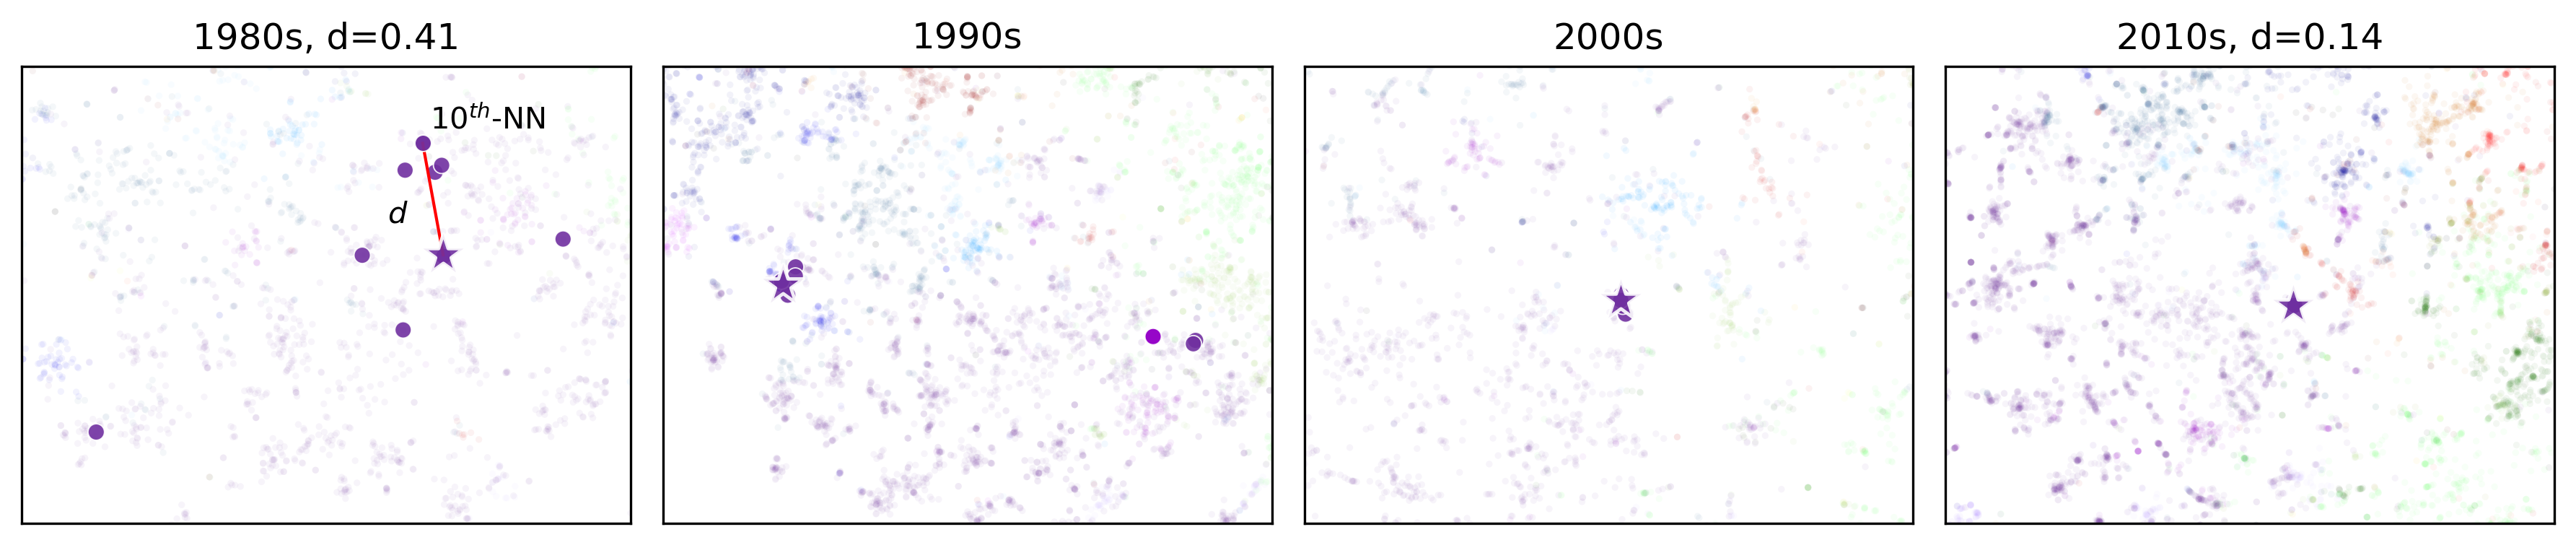

In [33]:
start_year_list = [1980, 1990, 2000, 2010]
end_year_list = [1989, 1999, 2009, 2021]
d = 100
w = 10


# Parameters used to control the display of the plot:
left_lim_list = [-50, -72, -44, -62]
right_lim_list = [30, 32, 0, 10]
low_lim_list = [-70, -69, -28, -23] 
up_lim_list = [-10, 9, 5, 31]
y_flip_list = [False, False, True, False]
rotate_180_list = [False, False, True, False]
rotate_90_clockwise_list = [True, True, False, False]

fig5 = plt.figure(figsize=(12, 3), dpi=300)
ax1 = fig5.add_subplot(1, 4, 1)
ax2 = fig5.add_subplot(1, 4, 2)
ax3 = fig5.add_subplot(1, 4, 3)
ax4 = fig5.add_subplot(1, 4, 4)
ax_list = [ax1, ax2, ax3, ax4]

ax1.title.set_text("1980s, d=0.41")
ax2.title.set_text("1990s")
ax3.title.set_text("2000s")
ax4.title.set_text("2010s, d=0.14")

for i in range(len(start_year_list)):
    start_year = start_year_list[i]
    end_year = end_year_list[i]

    wv = model.load_wv(start_year, end_year, 100, 10)

    VID_labeled = model.load_VID_labeled(start_year, end_year, 100, 10)
    tups = wv.most_similar(center_VID, topn=20)
    neighbor_VID_list = []
    for tup in tups:  
        neighbor_VID = tup[0]
        if neighbor_VID in VID_labeled['VID']:
            neighbor_VID_list.append(neighbor_VID)
        if len(neighbor_VID_list) >= 10:
            break
    print('number of neighbors: ', len(neighbor_VID_list))
    for neighbor_VID in neighbor_VID_list:
        print(model.MAG_venue_info_df.at[neighbor_VID, 'OriginalVenue'])

    wv_2d = model.load_wv_2d(start_year, end_year, d, w)
    plot_df = pd.DataFrame(wv_2d)
    plot_df = plot_df.loc[plot_df.VID.isin(VID_labeled['VID'])]
    plot_df['label'] = VID_labeled['label']
    plot_df['year_founded'] = VID_labeled['year_founded']
    plot_df['is_new'] = plot_df['year_founded'].apply(lambda x: 
                                                      0 if x==None
                                                      else 1 if int(x)>start_year
                                                      else 0)
    if i == 0:
        mark_d = True
    else:
        mark_d = False
    
    plot_tiny_knn_map(ax=ax_list[i], model=model, plot_df=plot_df,
                 legend=False, axis_off=False, mark_d=mark_d,
                 y_flip=y_flip_list[i], rotate_180=rotate_180_list[i], rotate_90_clockwise=rotate_90_clockwise_list[i],
                 crop=True, left_lim=left_lim_list[i], right_lim=right_lim_list[i], low_lim=low_lim_list[i], up_lim=up_lim_list[i],
                 annotate=False, highlight=True, center_VID=center_VID, neighbor_VID_list=neighbor_VID_list)
    
for ax in ax_list:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

fig5.tight_layout()

In [34]:
fig5.savefig('knn_map_of_{}.png'.format(center_vname), 
             dpi = 300, 
             facecolor='white', 
             transparent=False, 
             bbox_inches='tight')